In [1]:
using Oceananigans
using CairoMakie
using JLD2
using Statistics
using ImageFiltering: imfilter, Kernel.gaussian

[ Info: Oceananigans will use 4 threads


[ Info: Created a front state with Riₘᵢₙ = 1.0000022199142613, Roₘᵢₙ = -0.5578051909260751, Roₘₐₓ = 0.5832001548355947


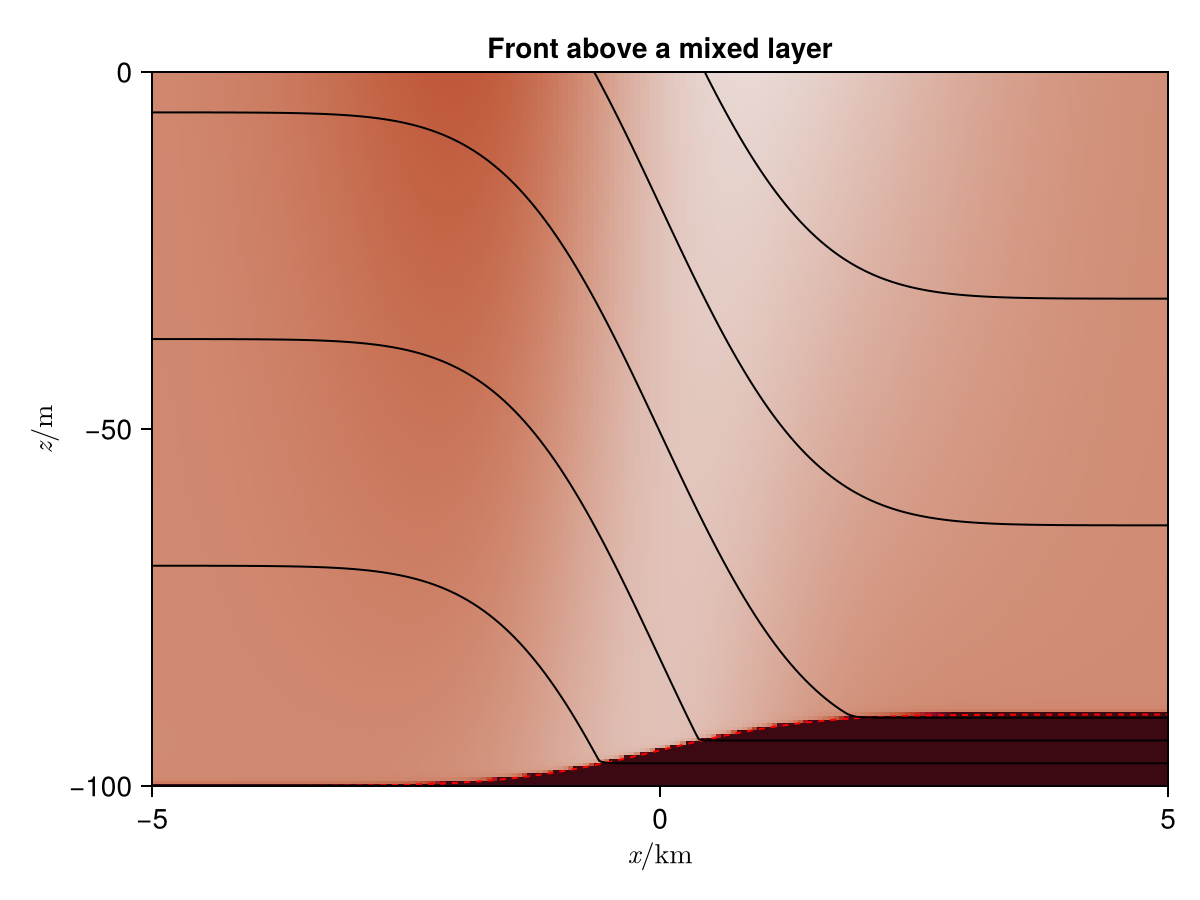

In [2]:
include("../src-fronts/parameters.jl")
include("../src-fronts/base_state.jl")
sp = create_simulation_parameters(; Ri=1, Ro=0.6, Q=100)
b, u, v, w = map(a->(x, z)->a(x, 0, z), get_base_state(sp));

ζ(x, z) = (v(x+5e-8, z) - v(x-5e-8, z)) / 1e-7
N²(x, z) = (b(x, z+5e-8) - b(x, z-5e-8)) / 1e-7
S(x, z) = (v(x, z+5e-8) - v(x, z-5e-8)) / 1e-7
M²(x, z) = (b(x+5e-8, z) - b(x-5e-8, z)) / 1e-7

q(x, z) = (ζ(x, z) + sp.f) * N²(x, z) - S(x, z) * M²(x, z)

xs = range(-sp.Lx/2000, sp.Lx/2000, 200)
zs = range(-sp.H, 0, 200)

Ri = [N²(x, z) / S(x, z)^2 for x in xs, z in zs]
Ro = [ζ(x * 1000, z) / sp.f for x in xs, z in zs]

Riₘᵢₙ = minimum(Ri)
Roₘᵢₙ = minimum(Ro)
Roₘₐₓ = maximum(Ro)

@info "Created a front state with Riₘᵢₙ = $Riₘᵢₙ, Roₘᵢₙ = $Roₘᵢₙ, Roₘₐₓ = $Roₘₐₓ"

fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(-sp.Lx/2000, sp.Lx/2000, -sp.H, 0))
h(x, z) = z - sp.H * γ(x/sp.ℓ, 0.1)

#contourf!(ax, xs, zs, (x, z)->v(1000x, z); levels=range(-2v(0, 0), 2v(0, 0), 20), colormap=:balance)
heatmap!(ax, xs, zs, (x, z)->q(1000x, z); colormap=:balance, colorrange=(-3sp.f * sp.N², 3sp.f * sp.N²))
contour!(ax, xs, zs, (x, z)->q(1000x, z); levels=[0], color=:blue)
contour!(ax, xs, zs, (x, z)->h(1000x, z); color=:red, levels=[0], linestyle=:dash)
contour!(ax, xs, zs, (x, z)->b(1000x, z); color=:black)
fig

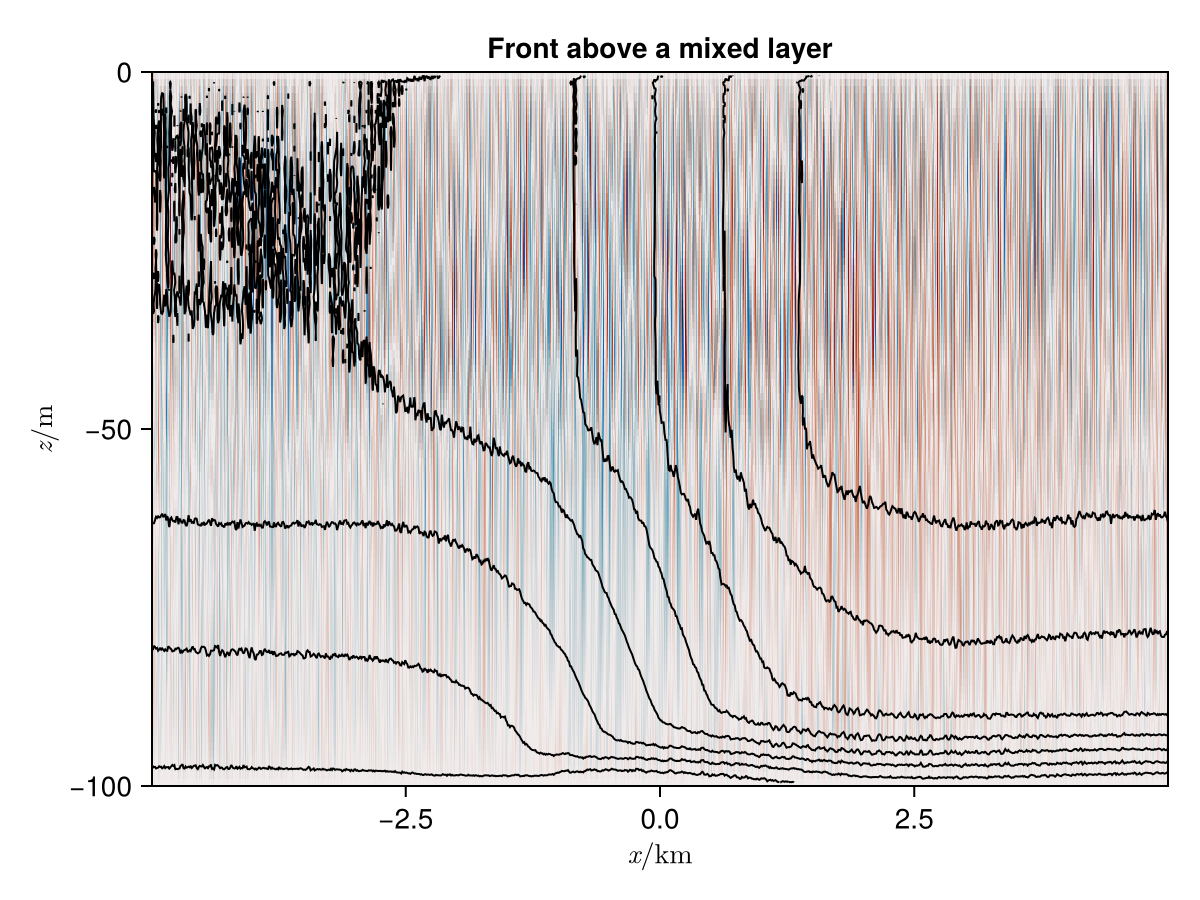

In [91]:
# Print simulation outputs
# Get a state of simulation
n = 51
foldername = "../../scratch/Project/front-no-spinup-Q10-Ri0"
sp = jldopen("$foldername/parameters.jld2") do file
    NamedTuple(map(keys(file)) do k
        Pair(Symbol(k), file[k])
            end)
end
filename = "$foldername/initialisation.jld2"
t, xs, ys, zs, u, v, w, b = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"][4:end-3]
    ys = file["grid/yᵃᶜᵃ"][4:end-3]
    zs = file["grid/zᵃᵃᶜ"][4:end-3]
    u = (file["timeseries/u/$frame"][1:end-1, :, :] .+ file["timeseries/u/$frame"][2:end, :, :]) ./ 2
    v = (circshift(file["timeseries/v/$frame"], (0, -1, 0)) .+ circshift(file["timeseries/v/$frame"], (0, 1, 0))) ./ 2
    w = (file["timeseries/w/$frame"][:, :, 1:end-1] .+ file["timeseries/w/$frame"][:, :, 2:end]) ./ 2
    b = file["timeseries/b/$frame"]
    
    ts[n], xs, ys, zs, u, v, w, b
    end;
fig = Figure()
ax = Axis(fig[1, 1]; xlabel=L"x / \text{km}", ylabel=L"z / \text{m}", title="Front above a mixed layer", limits=(xs[1]/1000, xs[end]/1000, -sp.H, 0))
#field = mean((v .- mean(v; dims=2)) .* (w .- mean(w; dims=2)); dims=2)[:, 1, :]
ψ = mean(cumsum(u; dims=3) * (zs[2]-zs[1]); dims=2)[:, 1, :]
#field = ψ - imfilter(ψ, gaussian((100, 0)))
b_levels = range(minimum(mean(b; dims=2)), maximum(mean(b; dims=2)), 10)
#field = field - imfilter(field, gaussian((10, 0)))
#field = circshift(mean(u; dims=2)[:, 1, :], (-1, 0)) .- circshift(mean(u; dims=2)[:, 1, :], (1, 0))
heatmap!(ax, xs / 1000, zs, field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, zs, mean(b; dims=2)[:, 1, :]; color=:black, levels=b_levels)
#contour!(ax, xs / 1000, zs, ψ; colormap=:balance, colorrange=(-maximum(abs, ψ), maximum(abs, ψ)), levels=3)

fig

In [ ]:
ψϕφ′

In [56]:
ts, xs, zs, u, v, w, b = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    frame = frames[n]
    xs = file["grid/xᶜᵃᵃ"][4:end-3]
    zs = file["grid/zᵃᵃᶜ"][4:end-3]
    
    u = [mean(file["timeseries/u/$frame"]; dims=2)[:, 1, :] for frame in frames]
    u = [u[j][i, k] for i in 1:length(xs), j in 1:length(frames), k in 1:length(zs)]
    v = [mean(file["timeseries/v/$frame"]; dims=2)[:, 1, :] for frame in frames]
    v = [v[j][i, k] for i in 1:length(xs), j in 1:length(frames), k in 1:length(zs)]
    w = [mean(file["timeseries/w/$frame"]; dims=2)[:, 1, :] for frame in frames]
    w = [w[j][i, k] for i in 1:length(xs), j in 1:length(frames), k in 1:length(zs)]
    b = [mean(file["timeseries/b/$frame"]; dims=2)[:, 1, :] for frame in frames]
    b = [b[j][i, k] for i in 1:length(xs), j in 1:length(frames), k in 1:length(zs)]
    ts, xs, zs, u, v, w, b
    end;

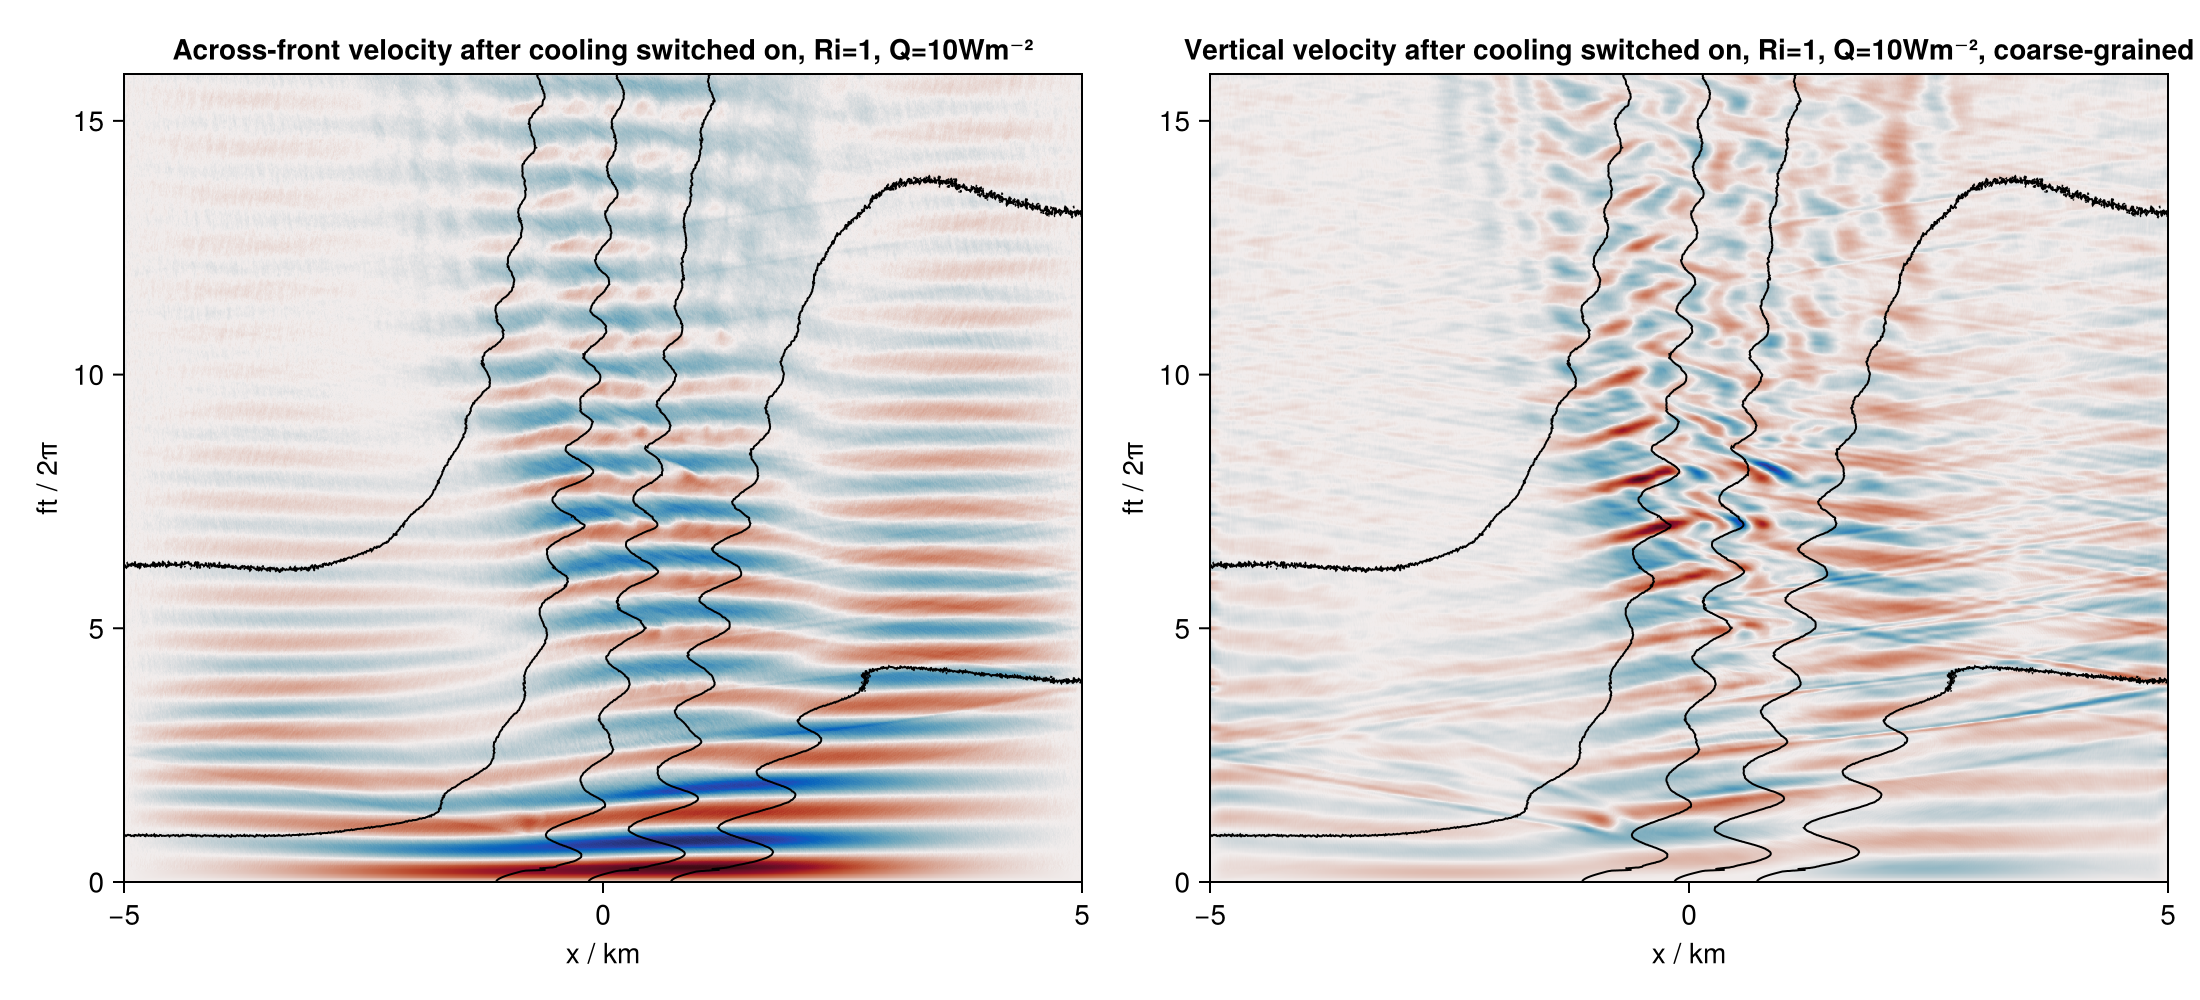

In [62]:
fig = Figure(; size=(1100, 500))
ax = Axis(fig[1, 1]; title = "Across-front velocity after cooling switched on, Ri=1, Q=10Wm⁻²", xlabel="x / km", ylabel="ft / 2π", limits=(nothing, (0, nothing)))
field = u[:, :, end-5]
heatmap!(ax, xs / 1000, ts * sp.f / (2π), field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, ts * sp.f / (2π), b[:, :, end-5]; color=:black)

ax = Axis(fig[1, 2]; title = "Vertical velocity after cooling switched on, Ri=1, Q=10Wm⁻², coarse-grained", xlabel="x / km", ylabel="ft / 2π", limits=(nothing, (0, nothing)))
field = imfilter(w[:, :, end-5], gaussian((10, 0)), "circular")
heatmap!(ax, xs / 1000, ts * sp.f / (2π), field; colormap=:balance, colorrange=(-maximum(abs, field), maximum(abs, field)))
contour!(ax, xs / 1000, ts * sp.f / (2π), b[:, :, end-5]; color=:black)
fig

In [71]:
heatmap(u[:, 601, :])

LoadError: MethodError: no method matching getindex(::var"#429#431"{var"#u₀#426"}, ::Colon, ::Int64, ::Colon)

In [58]:
file = jldopen("front-no-spinup-Q10-Ri1.jld2", "w")
file["u"] = u
file["v"] = v
file["w"] = w
file["b"] = b
file["ts"] = ts
file["xs"] = xs
file["zs"] = zs
file["sp"] = sp
close(file)

In [90]:
ts, zs, v′w′ = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    xs = file["grid/xᶜᵃᵃ"][4:end-3]
    ys = file["grid/yᵃᶜᵃ"][4:end-3]
    zs = file["grid/zᵃᵃᶜ"][4:end-3]
    v′w′ = map(frames) do frame
        v = (circshift(file["timeseries/v/$frame"], (0, -1, 0)) .+ circshift(file["timeseries/v/$frame"], (0, 1, 0))) ./ 2
        w = (file["timeseries/w/$frame"][:, :, 1:end-1] .+ file["timeseries/w/$frame"][:, :, 2:end]) ./ 2
        mean((v .- mean(v; dims=2)) .* (w .- mean(w; dims=2)); dims=(1, 2))[1, 1, :]
    end
    ts, zs, v′w′
    end;
v′w′ = [v′w′[i][j] for i in 1:length(v′w′), j in 1:length(v′w′[1])];

In [91]:
ts, us = jldopen(filename) do file
    frames = keys(file["timeseries/t"])
    ts = [file["timeseries/t/$frame"] for frame in frames]
    xs = file["grid/xᶜᵃᵃ"][4:end-3]
    ys = file["grid/yᵃᶜᵃ"][4:end-3]
    zs = file["grid/zᵃᵃᶜ"][4:end-3]
    us = map(frames) do frame
        mean(cumsum(file["timeseries/u/$frame"]; dims=3) * (zs[2]-zs[1]))
    end
    ts, us
    end;

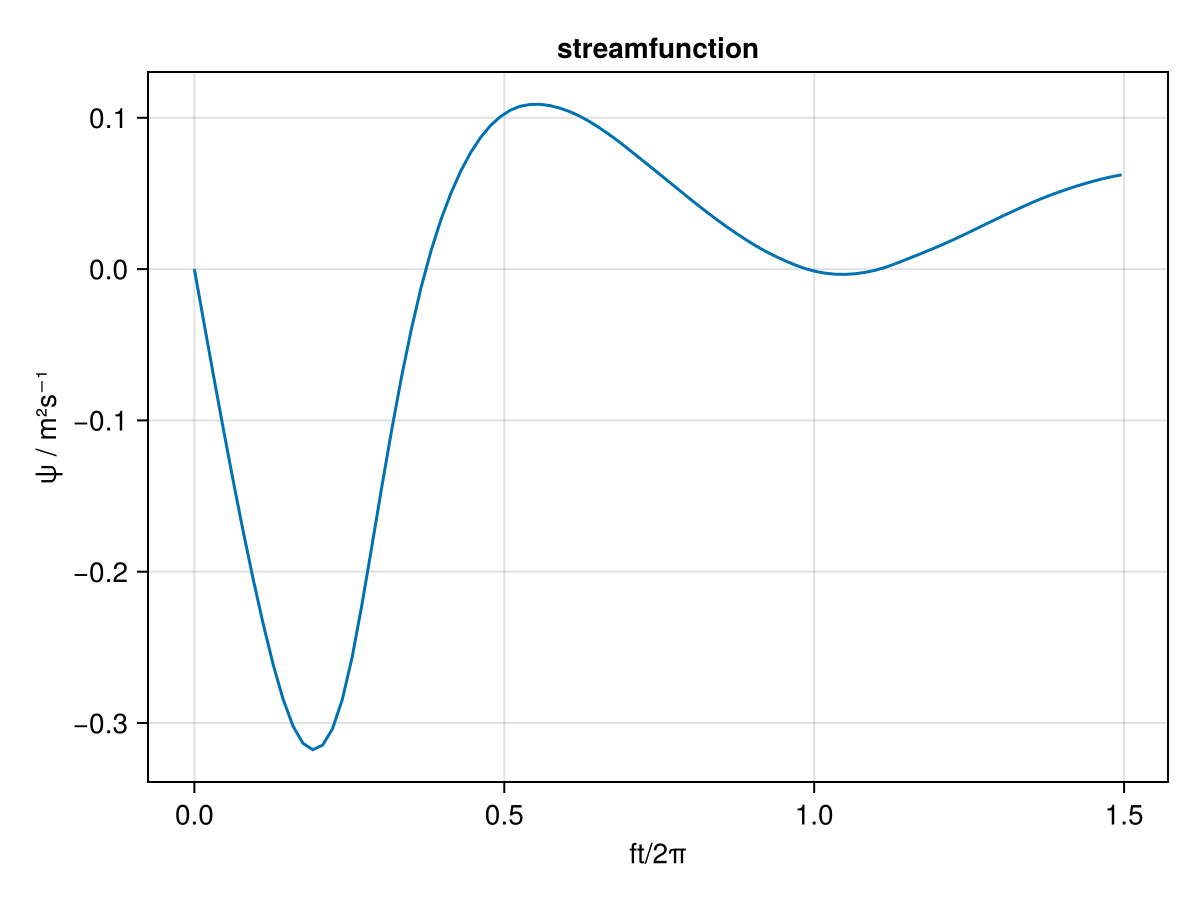

In [92]:
let
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="ft/2π", ylabel="ψ / m²s⁻¹", title="streamfunction")
    lines!(ax, sp.f * ts / (2π), us)
    fig
end

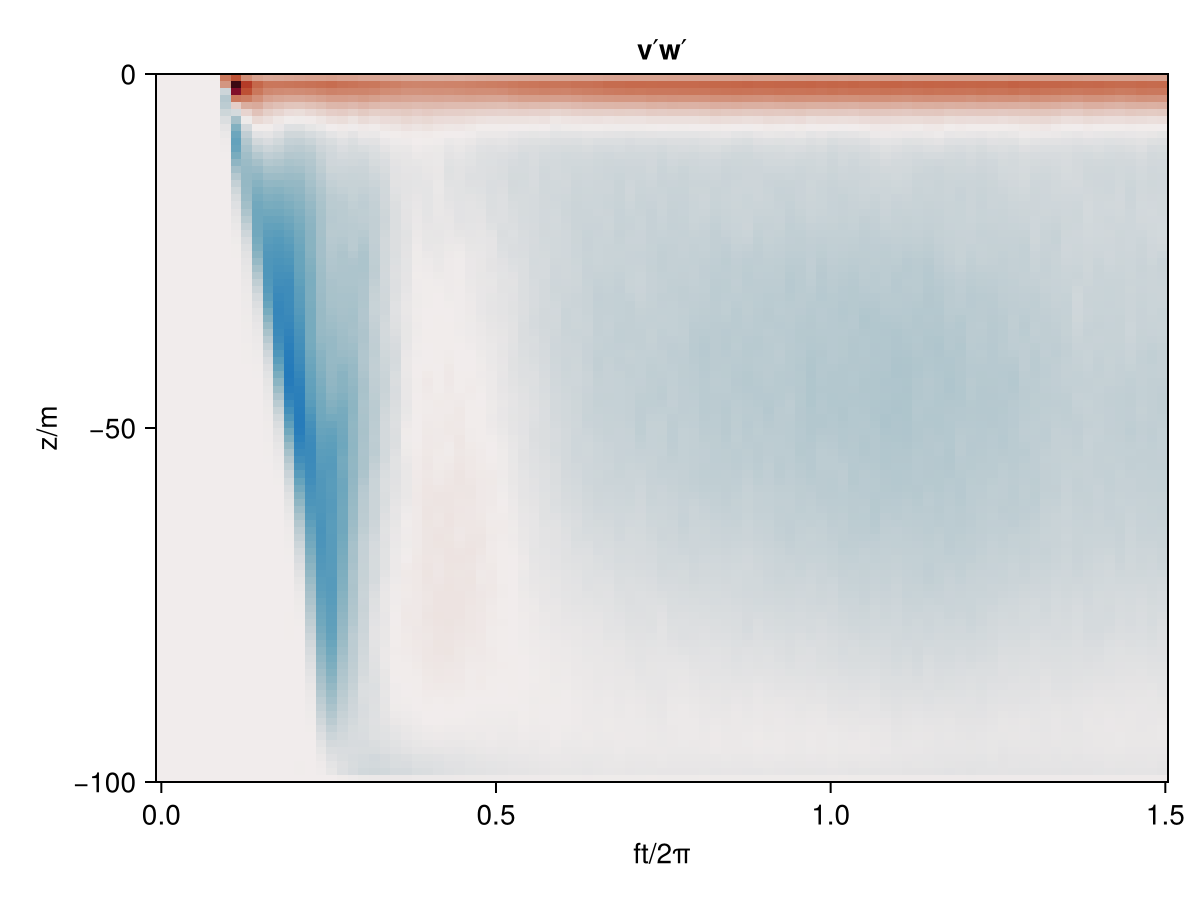

In [93]:
let
    fig = Figure()
    ax = Axis(fig[1, 1], xlabel="ft/2π", ylabel="z/m", title="v′w′")
    heatmap!(ax, sp.f * ts / (2π), zs, v′w′; colormap=:balance, colorrange=(-maximum(abs, v′w′), maximum(abs, v′w′)))
    fig
end